In [2]:
import pandas as pd
import  matplotlib.pyplot as plt
from datetime import datetime
from sklearn import datasets, linear_model
import seaborn as sb
import time
import numpy as np
% matplotlib inline
from math import radians, cos, sin, asin, sqrt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
from sklearn.ensemble import RandomForestRegressor

### Importing Data Files

In [3]:
train_file = "train/train.csv"
data = pd.read_csv(train_file, nrows= 2000000)

train_file = "test.csv"
test_data = pd.read_csv(train_file)

In [10]:
testdf = test_data
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 542.2+ KB


In [6]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## 1. Data Cleaning

In [16]:
def clean(data):
    #check for null values in the rows
    print(" Check Null Rows ")
    print(data.isnull().sum())

    #Removing NA values
    print("Prev Size: %d" % len(data))
    data = data.dropna(how = 'any', axis = 'rows')
    print("New Size: %d" % len(data))

    #fare amount should be positive
    print("Prev Size: %d" % len(data))
    data = data[(data.fare_amount > 0) & (data.fare_amount < 100)]
    print("New Size: %d" % len(data))
    
    # bounding the lat lon data using the values in the test data for more accuracy. 
    
    data = data[(test_data.pickup_longitude.min() <= data['pickup_longitude']) & (data['pickup_longitude'] <= test_data.pickup_longitude.max())]
    data = data[(test_data.dropoff_longitude.min() <= data['dropoff_longitude']) & (data['dropoff_longitude'] <= test_data.dropoff_longitude.max())]
    data = data[(test_data.pickup_latitude.min() <= data['pickup_latitude']) & (data['pickup_latitude'] <= test_data.pickup_latitude.max())]
    data = data[(test_data.dropoff_latitude.min() <= data['dropoff_latitude']) & (data['dropoff_latitude'] <= test_data.dropoff_latitude.max())]
    
    # Remove passenger count outliers
    data = data[(data['passenger_count'] > 0) & (data['passenger_count'] < 6)]
    return data  


In [22]:
# All methods used

def plot_fare_histogram(df):
    data[data.fare_amount <= 80].fare_amount.hist(bins=50, figsize=(14,3))
    plt.xlabel('fare $USD')
    plt.title('Histogram')

def convert_date(df):
    df['pickup_datetime'] = df['pickup_datetime'].map(lambda x: str(x)[:-4])
    df['pickup_datetime'] =  pd.to_datetime((df['pickup_datetime']), format='%Y-%m-%d %H:%M:%S.%f')
    
def euclidean_dist(df):
    df['distance'] = (df.pickup_longitude.sub(df.dropoff_longitude).pow(2).add(df.pickup_latitude.sub(df.dropoff_latitude).pow(2))).pow(.5)
     
def day_in_secs(data):
    #data['time_of_day'] = data.pickup_datetime.dt.hour
    data['time_of_day'] = data.pickup_datetime.dt.hour*60 +  data.pickup_datetime.dt.minute 
       
def haversine(lon1, lat1, lon2, lat2): # extracted from internet for calculating the actual distance traveled.
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 #radius of earth in kms
    return  c * r  
    
def fare_per_mile(fare,dist):
    if dist < 1:
        return 0
    val = fare/dist
    if math.isnan(val):
        return 0
    return val

def extra_features(data,isTest):
    data['hav_distance'] = data.apply(lambda row: haversine(row.pickup_longitude,row.pickup_latitude,row.dropoff_longitude,row.dropoff_latitude),axis=1)
    data['hour'] = data.pickup_datetime.dt.hour
    data['year'] = data.pickup_datetime.dt.year
    data['min'] = data.pickup_datetime.dt.minute
    data['week_day'] = data.pickup_datetime.dt.dayofweek
    if not isTest:
        data['fare_per_mile'] = data.apply(lambda row: fare_per_mile(row.fare_amount,row.hav_distance))

In [ ]:
# long_lat_diff(data)
data = clean(data)   
euclidean_dist(data)
convert_date(data)
day_in_secs(data)
extra_features(data)

In [10]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time_of_day,hav_distance,hour,min,week_day,fare_per_mile
count,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06,1.908985e+06
mean,1.127250e+01,-7.397517e+01,4.075106e+01,-7.397426e+01,4.075138e+01,1.597585e+00,3.403734e-02,8.400879e+02,3.322480e+00,1.350894e+01,2.955153e+01,3.041008e+00,inf
std,9.351220e+00,3.831083e-02,2.954447e-02,3.723455e-02,3.262337e-02,1.154078e+00,4.016153e-02,3.914059e+02,3.749715e+00,6.517116e+00,1.732432e+01,1.950046e+00,NaN
min,1.000000e-02,-7.426975e+01,4.049134e+01,-7.426948e+01,4.049023e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.433675e-03
25%,6.000000e+00,-7.399229e+01,4.073654e+01,-7.399159e+01,4.073553e+01,1.000000e+00,1.280857e-02,5.650000e+02,1.253880e+00,9.000000e+00,1.400000e+01,1.000000e+00,2.974380e+00
50%,8.500000e+00,-7.398210e+01,4.075333e+01,-7.398062e+01,4.075383e+01,1.000000e+00,2.179283e-02,8.790000e+02,2.151987e+00,1.400000e+01,3.000000e+01,3.000000e+00,3.837284e+00
75%,1.250000e+01,-7.396836e+01,4.076751e+01,-7.396538e+01,4.076838e+01,2.000000e+00,3.869515e-02,1.172000e+03,3.912652e+00,1.900000e+01,4.500000e+01,5.000000e+00,5.104956e+00
max,9.999000e+01,-7.296375e+01,4.169685e+01,-7.306468e+01,4.169126e+01,5.000000e+00,1.237685e+00,1.439000e+03,1.147885e+02,2.300000e+01,5.900000e+01,6.000000e+00,inf


In [11]:
data.to_pickle("processed_data.pickle")

## 2. Pearson correlation 

In [24]:
def display_plots(data):  
    #Euclidean distance of the ride and the taxi fare
    print("Pearson: : %f" % data['fare_amount'].corr(data['distance']))
    plt.title ('Distance vs Fare')
    plt.xlabel('Fare in USD')
    plt.ylabel('Distance')
    plt.scatter(data['fare_amount'],data['distance'])
    sb.regplot(x = data['fare_amount'], y = data['distance'], scatter=False, color ='red')
    plt.savefig('Distance-Fare.png')
    plt.show()
    
    #time of day and distance traveled
    print("Pearson: : %f" % data['time_of_day'].corr(data['distance']))
    plt.title ('Time vs Distance')
    plt.xlabel('Time in mins')
    plt.ylabel('Distance')
    plt.scatter(data['time_of_day'],data['distance'])
    plt.figure(figsize=(3,4))
    #sb.regplot(x = data['time_of_day'], y = data['distance'], scatter=False, color ='red')
    plt.savefig('Time-Distance.png')
    plt.show()
    
    #time of day and the taxi fare
    print("Pearson: : %f" % data['time_of_day'].corr(data['fare_amount']))
    plt.title ('Time vs Fare')
    plt.xlabel('Time in mins')
    plt.ylabel('Fare in USD')
    plt.scatter(data['time_of_day'],data['fare_amount'])
    #sb.regplot(x = data['time_of_day'], y = data['fare_amount'], scatter=False, color ='red')
    plt.savefig('Time-Fare.png')
    plt.show()
    

## 3. Visualization Plots

Pearson: : 0.839120


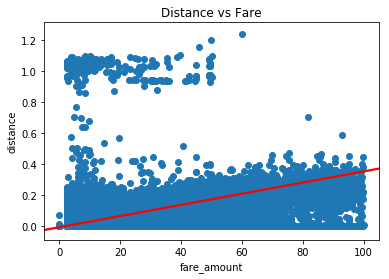

Pearson: : -0.030335


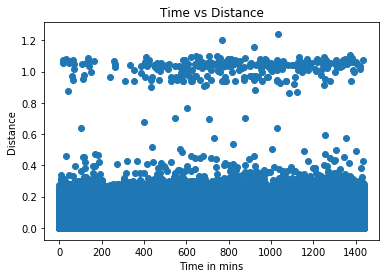

Pearson: : -0.018892


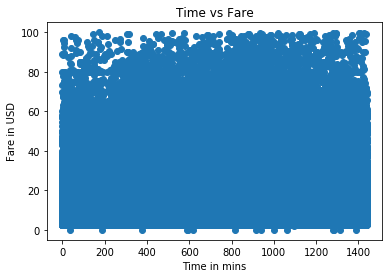

In [25]:
display_plots(data)

## 4. Exciting plot

Pearson: : 0.009405


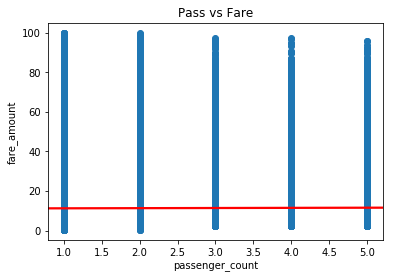

In [14]:
print("Pearson: : %f" % data['passenger_count'].corr(data['fare_amount']))
plt.title ('Pass vs Fare')
plt.xlabel('Pass')
plt.ylabel('Fare in USD')
plt.scatter(data['passenger_count'],data['fare_amount'])
sb.regplot(x = data['passenger_count'], y = data['fare_amount'], scatter=False, color ='red')
plt.savefig('Pass-Fare.png')
plt.show()

Pearson: : 0.011110


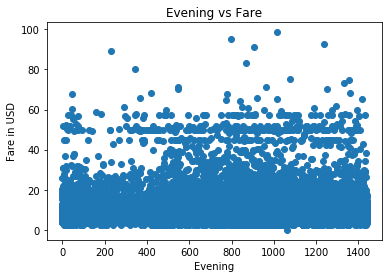

In [15]:
newdata =  data[(data.hav_distance > 1) & (data.hav_distance < 2)]
print("Pearson: : %f" % newdata['time_of_day'].corr(newdata['fare_amount']))
plt.title ('Evening vs Fare')
plt.xlabel('Evening')
plt.ylabel('Fare in USD')
plt.scatter(newdata['time_of_day'],newdata['fare_amount'])
plt.savefig('Evening-Fare.png')
plt.show()

## 5. Additional features

### 5.1 Haversine Distance

In [16]:
# data['hav_distance'] = data.apply(lambda row: haversine(row), axis=1)

Pearson: : 0.830551


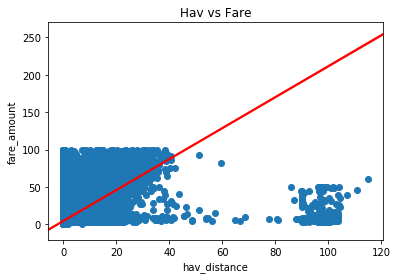

In [17]:
print("Pearson: : %f" % data['hav_distance'].corr(data['fare_amount']))
plt.title ('Hav vs Fare')
plt.xlabel('Hav')
plt.ylabel('Fare')
plt.scatter(data['hav_distance'],data['fare_amount'])
sb.regplot(x = data['hav_distance'], y = data['fare_amount'], scatter=False, color ='red')
plt.savefig('Haversine-Fare.png')
plt.show()

### 5.2  Week of the day

Text(0.5,1,'Histogram')

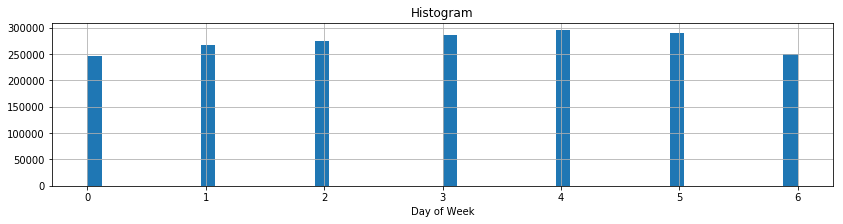

In [18]:
data.week_day.hist(bins=50, figsize=(14,3))
plt.xlabel('Day of Week')
plt.title('Histogram')

## 6. Linear Regression

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1908985 entries, 0 to 1999999
Data columns (total 15 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
distance             float64
time_of_day          int64
hav_distance         float64
hour                 int64
min                  int64
week_day             int64
fare_per_mile        float64
dtypes: datetime64[ns](1), float64(8), int64(5), object(1)
memory usage: 233.0+ MB


In [3]:
data = pd.read_pickle("processed_data.pickle")

In [21]:
grouped_df = data[data['hav_distance']>3].groupby('hour').mean()

In [22]:
x = []
y = []
for hour in grouped_df.index:
    x.append(hour)
    y.append(grouped_df.loc[hour]['fare_per_mile'])

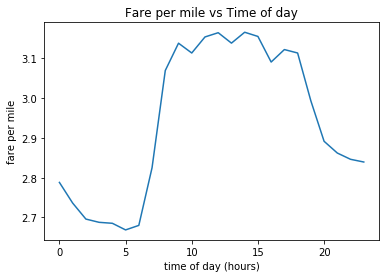

In [29]:
## Plotting the interesting plot.
plt.plot(x,y)
plt.xlabel("time of day (hours)")
plt.ylabel("fare per mile")
plt.title("Fare per mile vs Time of day")
plt.show()

In [26]:
train_df.dtypes

pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
distance             float64
time_of_day            int64
hav_distance         float64
hour                   int64
min                    int64
week_day               int64
fare_per_mile        float64
dtype: object

## External Dataset

In [19]:
# extracted the data from https://www.statista.com/statistics/204740/retail-price-of-gasoline-in-the-united-states-since-1990/

fuel_prices = {
    
    2009 : 2.35,
    2010 : 2.78,
    2011 : 3.52,
    2012 : 3.62,
    2013 : 3.51,
    2014 : 3.36,
    2015 : 2.43  
}

data['fuel_price'] = data.apply(lambda row: fuel_prices[row.year],axis=1)


## Machine Learning models.

In [15]:
# Linear Regression - executed the same code for baseline and extra features

train_df = data.drop(['key','fare_amount','pickup_datetime','fare_per_mile'],axis=1)
y = data['fare_amount']
x_train, x_test, y_train, y_test = train_test_split(train_df,y,test_size=0.2)

my_regression = linear_model.LinearRegression() 
my_regression.fit(x_train,y_train) 
my_regression_pred = my_regression.predict(x_test)
print(sqrt(mean_squared_error(y_test,my_regression_pred)))
print(x_train.head(1))
print(abs(my_regression.coef_))

4.853407196153514
        pickup_longitude  pickup_latitude  dropoff_longitude  \
541148        -73.786715        40.645167         -73.991368   

        dropoff_latitude  passenger_count  distance  time_of_day  \
541148          40.74895                1  0.229464          836   

        hav_distance  hour  min  week_day  year  fuel_price  
541148     20.756824    13   56         6  2014        3.36  
[  4.77489076e+00   2.00123835e+01   4.65063931e+00   1.28443102e+01
   4.87519443e-02   2.35661686e+02   1.77278704e-04   5.23349415e-01
   2.77310346e-05   1.48658346e-03   4.57977454e-02   5.40299238e-01
   2.70476250e-01]


## LR model output. 

### baseline:

7.98641279298705
         pickup_longitude  pickup_latitude  dropoff_longitude  \
1180892        -73.956776        40.716779         -73.967606   

         dropoff_latitude  passenger_count  
1180892         40.696095                1  
[  8.41943993e+01   6.14012544e+01   5.85318468e+01   5.26527986e+01
   5.69374850e-02]
   
### With all features:

4.983517340753283
         pickup_longitude  pickup_latitude  dropoff_longitude  \
1020632        -73.997088        40.720583         -74.003835   

         dropoff_latitude  passenger_count  distance  time_of_day  \
1020632         40.737548                3  0.018257          118   

         hav_distance  hour  min  week_day  
1020632      1.970232     1   58         0  
[  4.94095915e+00   1.92951635e+01   4.24857434e+00   1.30262236e+01
   9.91310155e-03   2.38931212e+02   1.79354252e-04   5.46349652e-01
   2.66731362e-05   1.42103403e-03   4.17557421e-02]
   
   
### With the extended dataset:
   
 4.853407196153514
        pickup_longitude  pickup_latitude  dropoff_longitude  \
541148        -73.786715        40.645167         -73.991368   

        dropoff_latitude  passenger_count  distance  time_of_day  \
541148          40.74895                1  0.229464          836   

        hav_distance  hour  min  week_day  year  fuel_price  
541148     20.756824    13   56         6  2014        3.36  
[  4.77489076e+00   2.00123835e+01   4.65063931e+00   1.28443102e+01
   4.87519443e-02   2.35661686e+02   1.77278704e-04   5.23349415e-01
   2.77310346e-05   1.48658346e-03   4.57977454e-02   5.40299238e-01
   2.70476250e-01]

## Generating the submission file.

In [18]:
test_data = pd.read_csv("test.csv")
euclidean_dist(test_data)
convert_date(test_data)
day_in_secs(test_data)
extra_features(test_data,True)
test_key = test_data['key']
test_data = test_data.drop(['key','pickup_datetime'],axis=1)

In [20]:
my_regression_op = my_regression.predict(test_data)

In [21]:
submit = pd.DataFrame({'key': test_key,'fare_amount':my_regression_op},columns=['key','fare_amount'])

submit.to_csv("b_submission_5.csv",index=False)

## Random Forest Regressor

In [ ]:
train_df = data.drop(['key','fare_amount','pickup_datetime','fare_per_mile'],axis=1)
y = data['fare_amount']
x_train, x_test, y_train, y_test = train_test_split(train_df,y,test_size=0.2)

rfr_regressor = RandomForestRegressor(n_jobs=-1,n_estimators=120,max_depth=6)
rfr_regressor.fit(x_train,y_train)
rfr_regressor_pred = rfr_regressor.predict(x_test)
print(sqrt(mean_squared_error(y_test,rfr_regressor_pred)))

In [25]:
print(sqrt(mean_squared_error(y_test,rfr_regressor_pred)))
rfr_regressor_pred_sub = rfr_regressor.predict(test_data)

4.000707565365393


In [26]:
submit = pd.DataFrame({'key': test_key,'fare_amount':rfr_regressor_pred_sub},columns=['key','fare_amount'])

submit.to_csv("b_submission_rfr.csv",index=False)